### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-01 14:32:50,185	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 12 (seed=3280187943, Wed Feb  1 14:32:51 2023)


In [3]:
trainer.train(100, 'centered1')

         iter : 1
pop_best_eval : -29.427101135253906
  median_eval : -951.0613403320312
    mean_eval : -924.6002807617188
    best_eval : -29.427101135253906
   worst_eval : -1959.2308349609375

         iter : 2
pop_best_eval : 2.0187087059020996
  median_eval : -888.1337890625
    mean_eval : -908.9271240234375
    best_eval : 2.0187087059020996
   worst_eval : -2114.978515625

         iter : 3
pop_best_eval : 2.1388025283813477
  median_eval : -959.6377563476562
    mean_eval : -833.9876098632812
    best_eval : 2.1388025283813477
   worst_eval : -2114.978515625

         iter : 4
pop_best_eval : 0.20251035690307617
  median_eval : -427.0086364746094
    mean_eval : -505.36614990234375
    best_eval : 2.1388025283813477
   worst_eval : -2114.978515625

         iter : 5
pop_best_eval : 2.4581785202026367
  median_eval : -665.7050170898438
    mean_eval : -474.45489501953125
    best_eval : 2.4581785202026367
   worst_eval : -2114.978515625

         iter : 6
pop_best_eval : 3.670

In [4]:
network = trainer.problem.parameterize_net(trainer.searcher.status['center'])

In [5]:
network = trainer.get_trained_network()

#### Visualize trained network

In [6]:
organism = generate_organism(50, device)
graph = organism.toGraph()
visualizer = Visualizer()

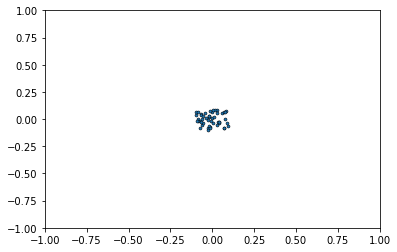

In [7]:
anim = visualizer.animate_organism(graph, network, frames=200)
IPython.display.HTML(anim)